In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


In [2]:
import seaborn as sns

In [3]:
import os

In [4]:
import PIL.Image as pilimg

In [5]:
import tensorflow
import keras

Using TensorFlow backend.


In [201]:
from keras.applications import xception, vgg16, inception_v3, resnet50, mobilenet, 
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm

In [47]:
from keras.applications.xception import *

In [7]:
from keras.applications.imagenet_utils import decode_predictions

In [8]:
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid

In [9]:
data_dir = '../../data/plant_seed/plant-seeding-classification/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir,'test')
sample_submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

In [10]:
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']

In [11]:
SEED = 42

In [12]:
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 654 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images


In [13]:
train =[]
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        file_name = 'train/{}/{}'.format(category, file)
        file_location = os.path.join(data_dir, file_name)
        im = pilimg.open(file_location)
        pix = np.array(im)
        height, width = pix.shape[:2]
        
        train.append(['train/{}/{}'.format(category, file), category_id, category, height, width])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category', 'height', 'width'])

train.shape

(4750, 5)

In [14]:
train.head()

,file,category_id,category,height,width
0,train/Black-grass/e47987eab.png,0,Black-grass,1320,1321
1,train/Black-grass/31958c132.png,0,Black-grass,400,400
2,train/Black-grass/f423f84da.png,0,Black-grass,749,749
3,train/Black-grass/cc90c662f.png,0,Black-grass,128,128
4,train/Black-grass/9052e3e7f.png,0,Black-grass,158,158


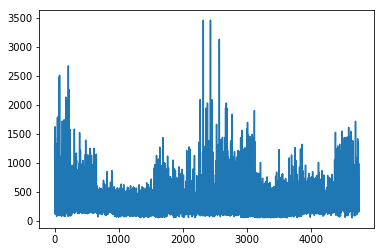

In [15]:
train.height.plot()

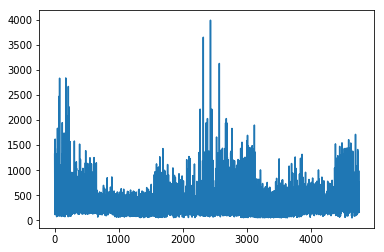

In [16]:
train.width.plot()

# Sample 추출

In [17]:
train[(train['height'] >=300) & (train['height']<500)  ]['category'].value_counts()

Charlock                     141
Small-flowered Cranesbill    137
Common Chickweed             116
Loose Silky-bent             114
Cleavers                     110
Fat Hen                      109
Sugar beet                    90
Shepherds Purse               50
Scentless Mayweed             47
Black-grass                   46
Maize                         36
Common wheat                  33
Name: category, dtype: int64

In [18]:
train_sample = train[(train['height'] >=300) & (train['height']<500)  ]

In [20]:
SAMPLE_PER_CATEGORY = 50

In [21]:
train_sample = pd.concat([train_sample[train_sample['category']==c][:SAMPLE_PER_CATEGORY] for c in CATEGORIES])

In [22]:
train_sample['category'].value_counts()

Fat Hen                      50
Loose Silky-bent             50
Small-flowered Cranesbill    50
Shepherds Purse              50
Cleavers                     50
Sugar beet                   50
Charlock                     50
Common Chickweed             50
Scentless Mayweed            47
Black-grass                  46
Maize                        36
Common wheat                 33
Name: category, dtype: int64

In [23]:
train_sample.head()

,file,category_id,category,height,width
1,train/Black-grass/31958c132.png,0,Black-grass,400,400
6,train/Black-grass/448a59eac.png,0,Black-grass,372,372
10,train/Black-grass/9959fb099.png,0,Black-grass,372,372
22,train/Black-grass/0d1a9985f.png,0,Black-grass,354,354
26,train/Black-grass/54c6dbde4.png,0,Black-grass,371,371


In [24]:
train_sample = train_sample.sample(frac=1, random_state=42)
train_sample.head()

,file,category_id,category,height,width
3970,train/Small-flowered Cranesbill/0ff5ac7e1.png,10,Small-flowered Cranesbill,366,366
3849,train/Shepherds Purse/1022cc155.png,9,Shepherds Purse,378,378
3626,train/Scentless Mayweed/2de4ec934.png,8,Scentless Mayweed,495,495
380,train/Charlock/de0e95661.png,1,Charlock,397,397
2949,train/Maize/96d476790.png,7,Maize,483,483


In [25]:
train_sample.index = np.arange(len(train_sample))
train_sample.head()

,file,category_id,category,height,width
0,train/Small-flowered Cranesbill/0ff5ac7e1.png,10,Small-flowered Cranesbill,366,366
1,train/Shepherds Purse/1022cc155.png,9,Shepherds Purse,378,378
2,train/Scentless Mayweed/2de4ec934.png,8,Scentless Mayweed,495,495
3,train/Charlock/de0e95661.png,1,Charlock,397,397
4,train/Maize/96d476790.png,7,Maize,483,483


In [26]:
test =[]

for file in os.listdir(test_dir):
    file_name = 'test/{}'.format(file)
    file_location = os.path.join(data_dir, file_name)
    im = pilimg.open(file_location)
    pix = np.array(im)
    height, width = pix.shape[:2]

    test.append(['test/{}'.format(file), file,height, width])
test = pd.DataFrame(test, columns=['filepath','file', 'height', 'width'])

test.shape


(794, 4)

In [27]:
test.head()

,filepath,file,height,width
0,test/17d5e5ac4.png,17d5e5ac4.png,225,225
1,test/948cdb277.png,948cdb277.png,201,201
2,test/e1809cef2.png,e1809cef2.png,330,330
3,test/0c45ace27.png,0c45ace27.png,260,260
4,test/59e1cea8d.png,59e1cea8d.png,240,240


In [28]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

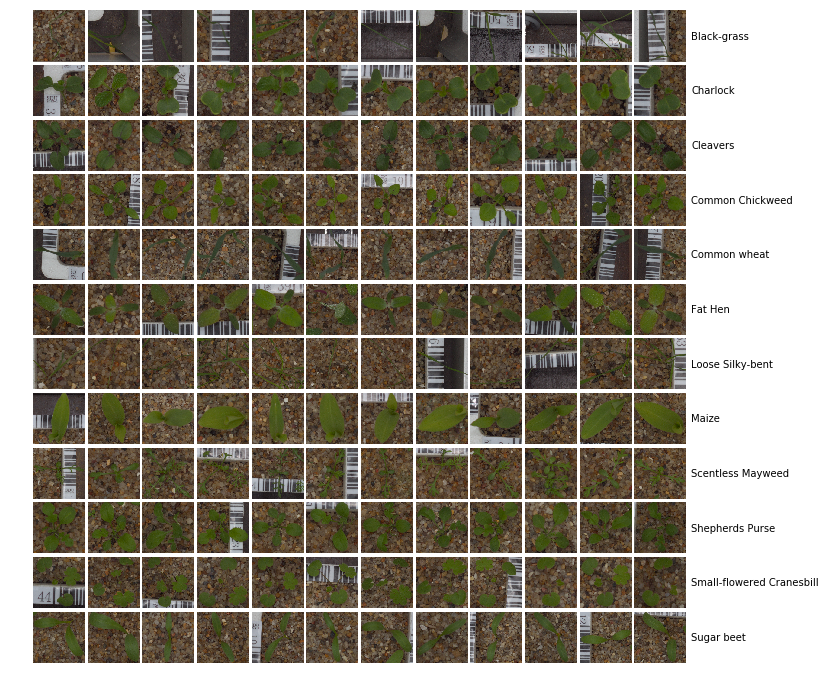

In [29]:
fig = plt.figure(1, figsize=(12,12))
grid = ImageGrid(fig, 111, nrows_ncols=(12,12), axes_pad=0.05)
i=0
for category_id, category in enumerate(CATEGORIES):
    for filepath in train_sample[train_sample['category'] == category]['file'].values[:12]:
        ax = grid[i]
        img = read_img(filepath, (224,224))
        ax.imshow(img/255.)
        ax.axis('off')
        if i % 12 == 11:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment = 'center')
        i += 1
plt.show()

# Validation split

In [30]:
np.random.seed(seed=SEED)
rnd = np.random.random(len(train_sample))

In [31]:
train_idx = rnd < 0.8
valid_idx = rnd >=0.8

In [32]:
Ytr = train_sample.loc[train_idx,'category_id'].values
Yv = train_sample.loc[valid_idx,'category_id'].values

In [33]:
train_idx[train_idx==True].shape, valid_idx[valid_idx==True].shape

((436,), (126,))

In [58]:
INPUT_SIZE = 299
POOLING = 'avg'
BATCH_SIZE = 16

In [35]:
x_train = np.zeros((len(train_sample), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, file in tqdm(enumerate(train_sample['file'])):
    img = read_img(file, (INPUT_SIZE, INPUT_SIZE))
#     x = keras.preprocessing.image(np.expand_dims(img.copy(), axis = 0))

    x  = img.astype('float32')
    x = x / 255
    x_train[i] = x

print('Train Images shape: {} size: {: ,}'.format(x_train.shape, x_train.size))

562it [00:03, 150.61it/s]

Train Images shape: (562, 299, 299, 3) size:  150,730,086


In [36]:
label_value  = pd.DataFrame.drop_duplicates(train_sample[['category_id', 'category']]).sort_values(by = ['category_id'])

In [37]:
Y_train_one_hot = keras.utils.to_categorical(Ytr, 12)
Y_valid_one_hot = keras.utils.to_categorical(Yv, 12)

In [38]:
Y_train_one_hot

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [39]:
X_train = x_train[train_idx]
X_valid = x_train[valid_idx]

In [63]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, BatchNormalization, Activation, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [41]:
def cnn_model():
#     keras.initializers()
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation = 'relu', input_shape =(INPUT_SIZE, INPUT_SIZE,3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (3,3)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64, (3,3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64, (3,3), activation = 'relu'))
    model.add(Conv2D(64, (3,3), activation = 'relu'))
    model.add(Conv2D(64, (3,3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.3))
    
    model.add(Flatten())

    # model.add(Dense(4096, activation='relu'))
    # model.add(Dense(2048, activation='relu'))
    # model.add(Dense(1024, activation='relu'))
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(12, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    
    return model

In [73]:
model_path = './fm_cnn_BN.h5'

In [82]:
callbacks = [
#     EarlyStopping(monitor='val_acc', patience=10, mode = 'max', verbose=1),
    ModelCheckpoint(model_path, monitor='val_acc', save_weights_only=True, mode='max', verbose = 0,)
]

In [83]:
img_generator = image.ImageDataGenerator(
    rotation_range = 180,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range =0.3,
    horizontal_flip= True,
    vertical_flip=True
)

In [84]:
img_generator.fit(X_train)

In [85]:
base_model = Xception(weights='imagenet', input_shape=(INPUT_SIZE,INPUT_SIZE,3), include_top=False)

In [231]:
base_model.input

<tf.Tensor 'input_5:0' shape=(?, 299, 299, 3) dtype=float32>

In [86]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

In [87]:
prediction = Dense(12, activation='softmax')(x)

In [88]:
model = Model(inputs = base_model.input, outputs = prediction)

In [232]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [89]:
model.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics =['accuracy'])

In [90]:
model.fit_generator(img_generator.flow(X_train, Y_train_one_hot, batch_size=BATCH_SIZE), steps_per_epoch=len(X_train)//BATCH_SIZE, epochs=100, verbose = 1,validation_data=(X_valid, Y_valid_one_hot), callbacks=callbacks)

Epoch 1/100
27/27 [==============================] - 20s 723ms/step - loss: 2.3893 - acc: 0.1499 - val_loss: 2.3854 - val_acc: 0.1905
Epoch 2/100
27/27 [==============================] - 10s 387ms/step - loss: 1.5609 - acc: 0.4724 - val_loss: 3.6403 - val_acc: 0.3333
Epoch 3/100
27/27 [==============================] - 10s 388ms/step - loss: 1.1675 - acc: 0.6205 - val_loss: 6.8117 - val_acc: 0.3571
Epoch 4/100
27/27 [==============================] - 10s 388ms/step - loss: 0.8463 - acc: 0.7088 - val_loss: 6.8125 - val_acc: 0.2937
Epoch 5/100
27/27 [==============================] - 11s 398ms/step - loss: 0.5878 - acc: 0.7917 - val_loss: 4.8966 - val_acc: 0.5079
Epoch 6/100
27/27 [==============================] - 10s 381ms/step - loss: 0.8150 - acc: 0.7802 - val_loss: 6.1319 - val_acc: 0.3968
Epoch 7/100
27/27 [==============================] - 11s 399ms/step - loss: 0.7286 - acc: 0.7917 - val_loss: 7.3584 - val_acc: 0.3175
Epoch 8/100
27/27 [==============================] - 10s 388ms

Epoch 62/100
27/27 [==============================] - 11s 393ms/step - loss: 0.1164 - acc: 0.9722 - val_loss: 0.4010 - val_acc: 0.9524
Epoch 63/100
27/27 [==============================] - 11s 391ms/step - loss: 0.3323 - acc: 0.9148 - val_loss: 0.2112 - val_acc: 0.9286
Epoch 64/100
27/27 [==============================] - 11s 391ms/step - loss: 0.2922 - acc: 0.9192 - val_loss: 0.5429 - val_acc: 0.8968
Epoch 65/100
27/27 [==============================] - 11s 399ms/step - loss: 0.1523 - acc: 0.9630 - val_loss: 1.0479 - val_acc: 0.8492
Epoch 66/100
27/27 [==============================] - 11s 393ms/step - loss: 0.3396 - acc: 0.9148 - val_loss: 1.4593 - val_acc: 0.8175
Epoch 67/100
27/27 [==============================] - 10s 382ms/step - loss: 0.1687 - acc: 0.9495 - val_loss: 0.2786 - val_acc: 0.9444
Epoch 68/100
27/27 [==============================] - 11s 401ms/step - loss: 0.1365 - acc: 0.9583 - val_loss: 0.5270 - val_acc: 0.9286
Epoch 69/100
27/27 [==============================] - 1

In [91]:
model.save_weights('./fm_cnn_BN_weights.h5')

In [92]:
test.head()

,filepath,file,height,width
0,test/17d5e5ac4.png,17d5e5ac4.png,225,225
1,test/948cdb277.png,948cdb277.png,201,201
2,test/e1809cef2.png,e1809cef2.png,330,330
3,test/0c45ace27.png,0c45ace27.png,260,260
4,test/59e1cea8d.png,59e1cea8d.png,240,240


In [94]:
train_sample.head()

,file,category_id,category,height,width
0,train/Small-flowered Cranesbill/0ff5ac7e1.png,10,Small-flowered Cranesbill,366,366
1,train/Shepherds Purse/1022cc155.png,9,Shepherds Purse,378,378
2,train/Scentless Mayweed/2de4ec934.png,8,Scentless Mayweed,495,495
3,train/Charlock/de0e95661.png,1,Charlock,397,397
4,train/Maize/96d476790.png,7,Maize,483,483


In [95]:
x_test = np.zeros((len(test), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, file in tqdm(enumerate(test['filepath'])):
    img = read_img(file, (INPUT_SIZE, INPUT_SIZE))
#     x = keras.preprocessing.image(np.expand_dims(img.copy(), axis = 0))

    x  = img.astype('float32')
    x = x / 255
    x_test[i] = x

print('Train Images shape: {} size: {: ,}'.format(x_test.shape, x_test.size))

794it [00:02, 266.81it/s]

Train Images shape: (794, 299, 299, 3) size:  212,953,182


In [96]:
model.load_weights('./fm_cnn_BN.h5')

In [100]:
x_test[:1].shape

(1, 299, 299, 3)

In [108]:
test_predict = model.predict(x_test)

In [113]:
CATEGORIES[np.where(test_predict==np.max(test_predict))]

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [121]:
test_predict.shape

(794, 12)

In [129]:
test.head()

,filepath,file,height,width
0,test/17d5e5ac4.png,17d5e5ac4.png,225,225
1,test/948cdb277.png,948cdb277.png,201,201
2,test/e1809cef2.png,e1809cef2.png,330,330
3,test/0c45ace27.png,0c45ace27.png,260,260
4,test/59e1cea8d.png,59e1cea8d.png,240,240


In [130]:
test['label_indices'] = np.argmax(test_predict,axis=1)
test.head()

,filepath,file,height,width,label_indices
0,test/17d5e5ac4.png,17d5e5ac4.png,225,225,6
1,test/948cdb277.png,948cdb277.png,201,201,2
2,test/e1809cef2.png,e1809cef2.png,330,330,8
3,test/0c45ace27.png,0c45ace27.png,260,260,3
4,test/59e1cea8d.png,59e1cea8d.png,240,240,2


In [133]:
test['label_indices'].value_counts()

3     106
11    103
6     101
10     79
8      72
0      67
1      56
5      54
2      49
9      43
7      39
4      25
Name: label_indices, dtype: int64

In [134]:
test['species'] = test['label_indices'].map(lambda x :CATEGORIES[x] )
test.head()

,filepath,file,height,width,label_indices,species
0,test/17d5e5ac4.png,17d5e5ac4.png,225,225,6,Loose Silky-bent
1,test/948cdb277.png,948cdb277.png,201,201,2,Cleavers
2,test/e1809cef2.png,e1809cef2.png,330,330,8,Scentless Mayweed
3,test/0c45ace27.png,0c45ace27.png,260,260,3,Common Chickweed
4,test/59e1cea8d.png,59e1cea8d.png,240,240,2,Cleavers


In [140]:
submit = test[['file','species']]
submit.head()

,file,species
0,17d5e5ac4.png,Loose Silky-bent
1,948cdb277.png,Cleavers
2,e1809cef2.png,Scentless Mayweed
3,0c45ace27.png,Common Chickweed
4,59e1cea8d.png,Cleavers


In [141]:
submit.sort_values(by = ['file'],inplace=True)
submit.head()

/home/jeongchanwoo/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,file,species
144,0021e90e4.png,Small-flowered Cranesbill
497,003d61042.png,Fat Hen
276,007b3da8b.png,Sugar beet
6,0086a6340.png,Common Chickweed
114,00c47e980.png,Sugar beet


In [142]:
submit.reset_index(inplace=True)
submit.drop(labels=['index'], axis =1,inplace=True)
submit.head()

/home/jeongchanwoo/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,file,species
0,0021e90e4.png,Small-flowered Cranesbill
1,003d61042.png,Fat Hen
2,007b3da8b.png,Sugar beet
3,0086a6340.png,Common Chickweed
4,00c47e980.png,Sugar beet


In [147]:
submit.to_csv('./mix_submission_re2.csv', header=True, index=False)

In [148]:
test_dir

'../../data/plant_seed/plant-seeding-classification/test'

In [152]:
test_predict[0]

array([5.9730471e-03, 1.8910908e-09, 1.3355074e-08, 3.6750001e-07,
       6.2915348e-09, 1.2729313e-08, 9.9402606e-01, 4.8711244e-09,
       4.3554928e-07, 3.1786975e-09, 1.5463343e-08, 7.0134725e-08],
      dtype=float32)

In [41]:
# model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [42]:
# hist = model.fit(X_train, Y_train_one_hot, batch_size=32, epochs=50, validation_data=(X_valid, Y_valid_one_hot))

In [43]:
# plt.plot(hist.history['loss'])
# plt.plot(hist.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Val'], loc='upper right')
# plt.show()

In [44]:
# plt.plot(hist.history['acc'])
# plt.plot(hist.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Val'], loc='lower right')
# plt.show()

In [45]:
img_generator = image.ImageDataGenerator(rotation_range=30, width_shift_range=0.05,height_shift_range=0.05)

In [46]:
train_data_flow = img_generator.flow(X_train, Y_train_one_hot,batch_size=32)

In [47]:
history = cnn_model().fit_generator(train_data_flow, epochs =50,  steps_per_epoch=10,verbose= 2 ,  validation_data=(X_valid, Y_valid_one_hot))

Epoch 1/50
 - 3s - loss: 2.6804 - acc: 0.1933 - val_loss: 3.1325 - val_acc: 0.0750
Epoch 2/50
 - 2s - loss: 1.9288 - acc: 0.3580 - val_loss: 2.0190 - val_acc: 0.3000
Epoch 3/50
 - 2s - loss: 1.4522 - acc: 0.4973 - val_loss: 3.6192 - val_acc: 0.1750
Epoch 4/50
 - 2s - loss: 1.1220 - acc: 0.6217 - val_loss: 3.1200 - val_acc: 0.2625
Epoch 5/50
 - 2s - loss: 0.8415 - acc: 0.7112 - val_loss: 1.8842 - val_acc: 0.4375
Epoch 6/50
 - 2s - loss: 0.7660 - acc: 0.7488 - val_loss: 1.6060 - val_acc: 0.4875
Epoch 7/50
 - 2s - loss: 0.7218 - acc: 0.7410 - val_loss: 0.9685 - val_acc: 0.7125
Epoch 8/50
 - 2s - loss: 0.5653 - acc: 0.8009 - val_loss: 0.8428 - val_acc: 0.6750
Epoch 9/50
 - 2s - loss: 0.4834 - acc: 0.8509 - val_loss: 0.8746 - val_acc: 0.6875
Epoch 10/50
 - 2s - loss: 0.4515 - acc: 0.8576 - val_loss: 1.0239 - val_acc: 0.6000
Epoch 11/50
 - 2s - loss: 0.3425 - acc: 0.9022 - val_loss: 1.1999 - val_acc: 0.5750
Epoch 12/50
 - 2s - loss: 0.3477 - acc: 0.8728 - val_loss: 1.3197 - val_acc: 0.5375
E

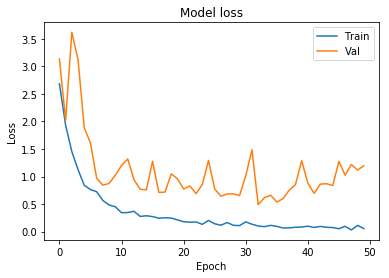

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

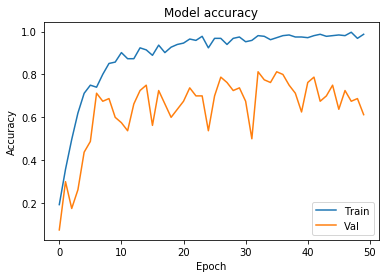

In [49]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [51]:
model = cnn_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 225, 225, 32)      896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 225, 225, 32)      128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 73, 73, 64)        18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 73, 73, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 24, 64)        0         
__________

In [52]:
img_generator = image.ImageDataGenerator(rotation_range=10, width_shift_range=0.05,height_shift_range=0.05)
# img_generator = image.ImageDataGenerator(rotation_range=0, width_shift_range=0,height_shift_range=0)
train_data_flow = img_generator.flow(X_train, Y_train_one_hot,batch_size=64)# 배치 32에서 늘림
history = cnn_model().fit_generator(train_data_flow, epochs =20,  steps_per_epoch=5,verbose= 1 ,  validation_data=(X_valid, Y_valid_one_hot))

Epoch 1/20
5/5 [==============================] - 3s 647ms/step - loss: 2.8624 - acc: 0.0979 - val_loss: 2.3521 - val_acc: 0.1500
Epoch 2/20
5/5 [==============================] - 2s 411ms/step - loss: 2.2230 - acc: 0.2820 - val_loss: 2.2272 - val_acc: 0.1500
Epoch 3/20
5/5 [==============================] - 2s 431ms/step - loss: 1.7970 - acc: 0.3826 - val_loss: 2.1182 - val_acc: 0.2625
Epoch 4/20
5/5 [==============================] - 2s 418ms/step - loss: 1.4239 - acc: 0.5190 - val_loss: 1.7331 - val_acc: 0.3375
Epoch 5/20
5/5 [==============================] - 2s 411ms/step - loss: 1.1212 - acc: 0.6348 - val_loss: 1.4588 - val_acc: 0.4375
Epoch 6/20
5/5 [==============================] - 2s 433ms/step - loss: 0.9914 - acc: 0.6554 - val_loss: 1.2645 - val_acc: 0.4875
Epoch 7/20
5/5 [==============================] - 2s 422ms/step - loss: 0.7749 - acc: 0.7498 - val_loss: 1.1960 - val_acc: 0.5375
Epoch 8/20
5/5 [==============================] - 2s 418ms/step - loss: 0.6557 - acc: 0.77

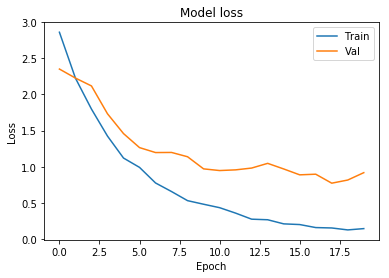

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

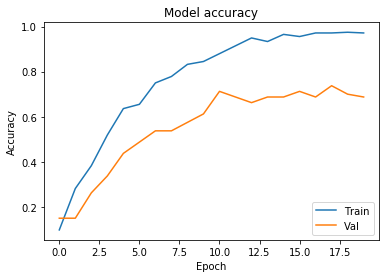

In [54]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [55]:
hist = cnn_model().fit(X_train, Y_train_one_hot, batch_size=64, epochs=20, validation_data=(X_valid, Y_valid_one_hot))

Train on 316 samples, validate on 80 samples
Epoch 1/20
316/316 [==============================] - 2s 6ms/step - loss: 2.8209 - acc: 0.1361 - val_loss: 2.6277 - val_acc: 0.0625
Epoch 2/20
316/316 [==============================] - 1s 2ms/step - loss: 2.0257 - acc: 0.3291 - val_loss: 2.3551 - val_acc: 0.1750
Epoch 3/20
316/316 [==============================] - 1s 2ms/step - loss: 1.4829 - acc: 0.4810 - val_loss: 1.9549 - val_acc: 0.2625
Epoch 4/20
316/316 [==============================] - 1s 2ms/step - loss: 1.1023 - acc: 0.6456 - val_loss: 1.7095 - val_acc: 0.3375
Epoch 5/20
316/316 [==============================] - 1s 2ms/step - loss: 0.8097 - acc: 0.7310 - val_loss: 1.4903 - val_acc: 0.4000
Epoch 6/20
316/316 [==============================] - 1s 2ms/step - loss: 0.6824 - acc: 0.7816 - val_loss: 1.3972 - val_acc: 0.4375
Epoch 7/20
316/316 [==============================] - 1s 2ms/step - loss: 0.4991 - acc: 0.8797 - val_loss: 1.4015 - val_acc: 0.4125
Epoch 8/20
316/316 [===========

# Extract Xception bottleneck features

In [85]:
INPUT_SIZE = 299
POOLING = 'avg'

In [86]:
x_train = np.zeros((len(train_sample), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, file in tqdm(enumerate(train_sample['file'])):
    img = read_img(file, (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis = 0))
    x_train[i] = x

print('Train Images shape: {} size: {: ,}'.format(x_train.shape, x_train.size))

396it [00:02, 147.57it/s]

Train Images shape: (396, 299, 299, 3) size:  106,208,388


In [91]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, Ytr.shape, Yv.shape))

((316, 299, 299, 3), (80, 299, 299, 3), (316,), (80,))


In [92]:
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)

83689472/83683744 [==============================] - 19s 0us/step


In [94]:
train_x_bf = xception_bottleneck.predict(Xtr, batch_size=16, verbose=1)
valid_x_bf = xception_bottleneck.predict(Xv, batch_size=16, verbose = 1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

80/80 [==============================] - 0s 5ms/step
Xception train bottleneck features shape: (316, 2048) size: 647,168
Xception valid bottleneck features shape: (80, 2048) size: 163,840


In [99]:
Xtr.shape

(316, 299, 299, 3)

In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

/home/jeongchanwoo/miniconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


In [103]:
logreg = LogisticRegression(multi_class='multinomial', solver ='lbfgs', random_state=SEED)
logreg.fit(train_x_bf, Ytr)
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)

In [131]:
valid_probs.argmax(axis =1)

array([ 3,  1,  1,  0,  8,  7, 10,  7,  5,  2,  5, 10,  7,  3,  7,  8,  9,
        0,  6,  9, 10,  5,  6,  6, 10,  9,  4,  8,  6,  1, 11,  8,  6,  5,
        2,  4, 11,  8,  4,  8,  4,  1, 11,  0,  8,  0,  3,  3,  5,  6,  9,
        4,  3,  7,  6,  1,  7,  1,  3,  3,  7,  5,  5,  2,  9,  6, 10,  5,
       10,  4,  8,  4,  3,  5,  7,  4,  2,  1,  3,  7])

In [132]:
valid_preds

array([ 3,  1,  1,  0,  8,  7, 10,  7,  5,  2,  5, 10,  7,  3,  7,  8,  9,
        0,  6,  9, 10,  5,  6,  6, 10,  9,  4,  8,  6,  1, 11,  8,  6,  5,
        2,  4, 11,  8,  4,  8,  4,  1, 11,  0,  8,  0,  3,  3,  5,  6,  9,
        4,  3,  7,  6,  1,  7,  1,  3,  3,  7,  5,  5,  2,  9,  6, 10,  5,
       10,  4,  8,  4,  3,  5,  7,  4,  2,  1,  3,  7])

In [105]:
print('Validataion Xception Accuracy {}'.format(accuracy_score(Yv, valid_preds)))

Validataion Xception Accuracy 0.8125


# Confusion matrix

In [106]:
cnf_matrix = confusion_matrix(Yv, valid_preds)

In [108]:
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']
pd.DataFrame({'class': CATEGORIES, 'abbreviation': abbreviation})

,class,abbreviation
0,Black-grass,BG
1,Charlock,Ch
2,Cleavers,Cl
3,Common Chickweed,CC
4,Common wheat,CW
5,Fat Hen,FH
6,Loose Silky-bent,LSB
7,Maize,M
8,Scentless Mayweed,SM
9,Shepherds Purse,SP


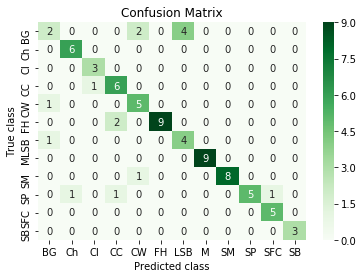

In [112]:
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax = ax ,cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
fig.savefig('Confusion matrix.png', dpi = 300)
plt.show()

# Other pre-trained model

In [146]:
# xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)
#Load the VGG model
vgg_model = vgg16.VGG16(weights='imagenet', include_top=False, pooling=POOLING)
 
#Load the Inception_V3 model
inception_model = inception_v3.InceptionV3(weights='imagenet', include_top=False, pooling=POOLING)
 
#Load the ResNet50 model
resnet_model = resnet50.ResNet50(weights='imagenet', include_top=False, pooling=POOLING)
 
#Load the MobileNet model
mobilenet_model = mobilenet.MobileNet(weights='imagenet', include_top=False, pooling=POOLING)

/home/jeongchanwoo/miniconda3/envs/tensorflow/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


17227776/17225924 [==============================] - 26s 2us/step


In [176]:
INPUT_SIZE = 224
POOLING = 'avg'

In [192]:
def image_trasform(train_sample, INPUT_SIZE, pre_model):
    x_train = np.zeros((len(train_sample), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
    for i, file in tqdm(enumerate(train_sample['file'])):
        img = read_img(file, (INPUT_SIZE, INPUT_SIZE))
#         print(img)
        x = pre_model.preprocess_input(np.expand_dims(img.copy(), axis = 0))
        x_train[i] = x

    print('Train Images shape: {} size: {: ,}'.format(x_train.shape, x_train.size))
    return x_train

In [193]:
def predict_proba(x_t, x_v, pre_model ):
    train_x_bf = pre_model.predict(x_t, batch_size=16, verbose=1)
    valid_x_bf = pre_model.predict(x_v, batch_size=16, verbose = 1)
    print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
    print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))
    
    return train_x_bf, valid_x_bf

In [194]:
# def evaluate(x_v_proba, y_v):
#     x_v_label = decode_predictions(x_v_proba)
# #     x_v_label = x_v_proba.argmax(axis =1)
# #     print('Validataion Xception Accuracy {}'.format(accuracy_score(y_v, x_v_label)))
#     return x_v_label

In [195]:
def evaluate(x_v_pro, y_v):
    print('Validataion Xception Accuracy {}'.format(accuracy_score(Yv, valid_preds)))
    return accuracy_score(Yv, valid_preds)

In [196]:
def pre_trained(pre_weight, pre_model):
    x_train = image_trasform(train_sample, INPUT_SIZE, pre_weight)
    Xtr = x_train[train_idx]
    Xv = x_train[valid_idx]
    print((Xtr.shape, Xv.shape, Ytr.shape, Yv.shape))
    train_proba, valid_proba = predict_proba(Xtr, Xv, pre_model)
    return (train_proba, valid_proba)
    

In [197]:
def label_classification(train_proba, Ytr, valid_proba):
    logreg = LogisticRegression(multi_class='multinomial', solver ='lbfgs', random_state=SEED)
    logreg.fit(train_proba, Ytr)
    valid_probs = logreg.predict_proba(valid_proba)
    valid_preds = logreg.predict(valid_proba)

    return evaluate(valid_preds, Yv)

In [198]:
vgg_16 = pre_trained(vgg16, vgg_model)
# inception_v3 = pre_trained(inception_v3, inception_model)
resnet_50 = pre_trained(resnet50, resnet_model)
# mobilenet = pre_trained(mobilenet, mobilenet_model)

396it [00:02, 149.49it/s]


Train Images shape: (396, 224, 224, 3) size:  59,609,088
((316, 224, 224, 3), (80, 224, 224, 3), (316,), (80,))
80/80 [==============================] - 0s 3ms/step
Xception train bottleneck features shape: (316, 512) size: 161,792
Xception valid bottleneck features shape: (80, 512) size: 40,960


396it [00:02, 148.75it/s]


Train Images shape: (396, 224, 224, 3) size:  59,609,088
((316, 224, 224, 3), (80, 224, 224, 3), (316,), (80,))
80/80 [==============================] - 0s 3ms/step
Xception train bottleneck features shape: (316, 2048) size: 647,168
Xception valid bottleneck features shape: (80, 2048) size: 163,840


In [199]:
vgg_score = label_classification(vgg_16[0], Ytr, vgg_16[1])
# inception_v3_score = label_classification(inception_v3[0], Ytr, inception_v3[1])
resnet_50_score = label_classification(resnet_50[0], Ytr, resnet_50[1])
# mobilenet_score = label_classification(mobilenet[0], Ytr, mobilenet[1])

Validataion Xception Accuracy 0.7875
Validataion Xception Accuracy 0.7875
